In [1]:
import pandas as pd
import numpy as np
import json
import sys
import random

import ast

import pymysql

from datetime import date

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
from matplotlib import cm
from matplotlib import colorbar
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.patches import RegularPolygon
from matplotlib.patches import ArrowStyle
from matplotlib.patches import Circle

from matplotlib.colors import Normalize
import matplotlib.patheffects as pe

import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from mplsoccer import VerticalPitch, Pitch, Radar, FontManager, grid, PyPizza

import scipy.stats as stats

from highlight_text import  ax_text, fig_text

from soccerplots.utils import add_image

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing

import abs_import

import statistics
import math
import ipywidgets as widgets

from IPython.display import display, Math, Latex

import warnings

plt.rcParams["figure.dpi"] = 300

from matplotlib import font_manager

from app import *

sys.path.append('Functions/visualization')

from Functions.utils import read_json
from Functions.visualization.passing_network import draw_pitch, draw_pass_map

clubColors = {'Brazil' : ['#fadb04', '#1c3474'],
              'Portugal' : ['#e1231b', '#004595'],
              'Argentina' : ['#52a9dc', '#dbe4ea'],
              'Saudi Arabia' : ['#145735', '#dbe4ea'],
              'Ghana' : ['#145735', '#dbe4ea'],
              'Serbia' : ['#FF0000', '#E8E8E8'],
              'Spain' : ['#FF0000', '#E8E8E8'],
              'Germany' : ['#aa9e56', '#FF0000'],
              'France' : ['#202960', '#d10827'],
              'Poland' : ['#d10827', '#E8E8E8'],
              'Morocco' : ['#db221b', '#044c34'],
              'Croatia' : ['#e71c23', '#3f85c5'],
              'Netherlands' : ['#f46c24', '#dcd9d7'],
              'Senegal' : ['#34964a', '#eedf36'],
              'Denmark' : ['#cb1617', '#E8E8E8'],
              'Iran' : ['#269b44', '#dd1212'],
              'Belgium' : ['#ff0000', '#e30613'],
              'USA' : ['#ff0000', '#202960'],
              'Switzerland' : ['#ff0000', '#e8e8e8'],
              'Australia' : ['#202960', '#e30613'],
              'Wales' : ['#ff0000', '#e8e8e8'],
              'Mexico' : ['#00a94f', '#ff0000'],
              'Uruguay' : ['#52a9dc', '#e8e8e8'],
              'Canada' : ['#ff0000', '#ff0000'],
              'Costa Rica' : ['#ff0000', '#202960']}

df = pd.read_csv('C:/Users/menes/Documents/Data Hub/Database/optaMundial.csv')
df["matchTimestamp"] = 60 * df["minute"] + df["second"]
df["matchTimestamp"] = pd.to_timedelta(df["matchTimestamp"], unit='s')
df.drop_duplicates(subset=['name', 'matchTimestamp', 'team', 'typedisplayName', 'x', 'y'], keep='first', inplace=True)
df.sort_values(by=['Match_ID', 'matchTimestamp'], inplace=True, ascending=[True, True])
df.reset_index(drop=True, inplace=True)

In [14]:
import plotly
import plotly.graph_objects as go
from PIL import Image

img = Image.open('pitch.png')
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=[0, 110, 112, 114, 115, 130],
               y=[0, 65, 55, 49, 53, 90],
                mode='markers',
                marker=dict(size=15,
                color='red'),
               name='Salah'
))

# axis hide、yaxis reversed
fig.update_layout(
    autosize=False,
    width=1163,
    height=783,
    xaxis=dict(visible=False,autorange=True),
    yaxis=dict(visible=False,autorange='reversed')
)

# background image add
fig.add_layout_image(
    dict(source=img,
         xref='x',
         yref='y',
         x=0,
         y=0,
         sizex=135,
         sizey=95,
         sizing='stretch',
         opacity=0.9,
         layer='below')
)

arrow = go.layout.Annotation(dict(
                x= 88,
                y= 59,
                xref="x", yref="y",
                text="",
                showarrow=True,
                axref = "x", ayref='y',
                ax= 70,
                ay= 50,
                arrowhead = 3,
                arrowwidth=1.5,
                arrowcolor='rgb(255,51,0)',)
            )

# Set templates
fig.update_layout(template="plotly_white")

fig.show()

# **Passing Network**

In [2]:
def xT(df, data):
  eventsPlayers_xT = df

  #Import xT Grid, turn it into an array, and then get how many rows and columns it has
  xT = pd.read_csv('C:/Users/menes/Documents/Data Hub/xT/xT_Grid.csv', header=None)
  xT = np.array(xT)
  xT_rows, xT_cols = xT.shape


  if data == 'WyScout':
    eventsPlayers_xT['x1_bin'] = pd.cut(eventsPlayers_xT['location.x'], bins=xT_cols, labels=False)
    eventsPlayers_xT['y1_bin'] = pd.cut(eventsPlayers_xT['location.y'], bins=xT_rows, labels=False)
    eventsPlayers_xT['x2_bin'] = pd.cut(eventsPlayers_xT['pass.endLocation.x'], bins=xT_cols, labels=False)
    eventsPlayers_xT['y2_bin'] = pd.cut(eventsPlayers_xT['pass.endLocation.y'], bins=xT_rows, labels=False)

    eventsPlayers_xT = eventsPlayers_xT[['player.name', 'team.name', 'minute', 'second', 'location.x', 'location.y', 'type.primary', 'type.secondary', 'pass.endLocation.x', 'pass.endLocation.y', 'x1_bin', 'y1_bin', 'x2_bin', 'y2_bin']]

    eventsPlayers_xT['start_zone_value'] = eventsPlayers_xT[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
    eventsPlayers_xT['end_zone_value'] = eventsPlayers_xT[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

    eventsPlayers_xT['xT'] = round(eventsPlayers_xT['end_zone_value'] - eventsPlayers_xT['start_zone_value'], 2)

    eventsPlayers_xT.drop(eventsPlayers_xT.index[0], axis=0, inplace=True)

    eventsPlayers_xT.reset_index(inplace=True)

    eventsPlayers_xT.drop(['index'], axis=1, inplace=True)
    
  elif data == 'WhoScored':
    eventsPlayers_xT['x1_bin'] = pd.cut(eventsPlayers_xT['x'], bins=xT_cols, labels=False)
    eventsPlayers_xT['y1_bin'] = pd.cut(eventsPlayers_xT['y'], bins=xT_rows, labels=False)
    eventsPlayers_xT['x2_bin'] = pd.cut(eventsPlayers_xT['endX'], bins=xT_cols, labels=False)
    eventsPlayers_xT['y2_bin'] = pd.cut(eventsPlayers_xT['endY'], bins=xT_rows, labels=False)

    eventsPlayers_xT = eventsPlayers_xT[['id', 'Match_ID', 'matchTimestamp', 'outcomeTypedisplayName', 'name', 'team', 'minute', 'second', 'x', 'y', 'typedisplayName', 'isTouch', 'endX', 'endY', 'x1_bin', 'y1_bin', 'x2_bin', 'y2_bin']]

    eventsPlayers_xT['start_zone_value'] = eventsPlayers_xT[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
    eventsPlayers_xT['end_zone_value'] = eventsPlayers_xT[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

    eventsPlayers_xT['xT'] = round(eventsPlayers_xT['end_zone_value'] - eventsPlayers_xT['start_zone_value'], 2)

    eventsPlayers_xT.drop(eventsPlayers_xT.index[0], axis=0, inplace=True)

    eventsPlayers_xT.reset_index(inplace=True)

    eventsPlayers_xT.drop(['index'], axis=1, inplace=True)
  
  elif data == 'BePro':
    eventsPlayers_xT['x1_bin'] = pd.cut(eventsPlayers_xT['x_start'], bins=xT_cols, labels=False)
    eventsPlayers_xT['y1_bin'] = pd.cut(eventsPlayers_xT['y_start'], bins=xT_rows, labels=False)
    eventsPlayers_xT['x2_bin'] = pd.cut(eventsPlayers_xT['x_end'], bins=xT_cols, labels=False)
    eventsPlayers_xT['y2_bin'] = pd.cut(eventsPlayers_xT['y_end'], bins=xT_rows, labels=False)

    eventsPlayers_xT = eventsPlayers_xT[['id', 'Match_ID', 'matchTimestamp', 'team_name', 'player_name', 'event_time', 'x_start', 'y_start', 'eventType', 'x_end', 'y_end', 'x1_bin', 'y1_bin', 'x2_bin', 'y2_bin']]

    eventsPlayers_xT['start_zone_value'] = eventsPlayers_xT[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
    eventsPlayers_xT['end_zone_value'] = eventsPlayers_xT[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

    eventsPlayers_xT['xT'] = round(eventsPlayers_xT['end_zone_value'] - eventsPlayers_xT['start_zone_value'], 2)

    eventsPlayers_xT.drop(eventsPlayers_xT.index[0], axis=0, inplace=True)

    eventsPlayers_xT.reset_index(inplace=True)

    eventsPlayers_xT.drop(['index'], axis=1, inplace=True)

  return eventsPlayers_xT

In [3]:
def passing_networkWhoScored(team, gameDay, afterSub=None):

        if gameDay != 'All Season':
            dataDF = df.loc[df.Match_ID == gameDay].reset_index(drop=True)
            
        elif gameDay == 'All Season':
            dataDF = df.copy()

        color = clubColors.get(team)

        data = xT(dataDF, 'WhoScored')

        ###########################################################################################################################
        if gameDay != 'All Season':
            network = data.loc[(data['team'] == team) & (data['Match_ID'] == gameDay)].reset_index(drop=True)
            
        elif gameDay == 'All Season':
            network = data.loc[(data['team'] == team)].reset_index(drop=True)
            
        network = network.sort_values(['matchTimestamp'], ascending=True)

        network["newsecond"] = 60 * network["minute"] + network["second"]

        #find time of the team's first substitution and filter the df to only passes before that
        Subs = network.loc[(network['typedisplayName'] == "SubstitutionOff")]
        SubTimes = Subs["newsecond"]
        SubOne = SubTimes.min()

        passes = network.loc[(network['typedisplayName'] == "Pass") &
                             (network['outcomeTypedisplayName'] == 'Successful')].reset_index(drop=True)


        ###########################################################################################################################
        if afterSub == None:
          passes = passes.loc[passes['newsecond'] < SubOne].reset_index(drop=True)

        elif afterSub != None:
          passes = passes.loc[passes['newsecond'] > SubOne].reset_index(drop=True)

        ###########################################################################################################################

        passes['passer'] = passes['name']
        passes['recipient'] = passes['passer'].shift(+1)
        passes['passer'] = passes['passer'].astype(str)
        passes['recipient'] = passes['recipient'].astype(str)

        #passes = passes.loc[passes['recipient'] != 'nan']

        ###########################################################################################################################

        avg = passes.groupby('passer').agg({'x':['mean'], 'y':['mean', 'count']})
        avg.columns = ['x_avg', 'y_avg', 'count']

        player_pass_count = passes.groupby("passer").size().to_frame("num_passes")
        player_pass_value = passes.groupby("passer")['xT'].sum().to_frame("pass_value")

        passes["pair_key"] = passes.apply(lambda x: "_".join(sorted([x["passer"], x["recipient"]])), axis=1)
        pair_pass_count = passes.groupby("pair_key").size().to_frame("num_passes")
        pair_pass_value = passes.groupby("pair_key")['xT'].sum().to_frame("pass_value")

        ###########################################################################################################################

        btw = passes.groupby(['passer', 'recipient']).id.count().reset_index()
        btw.rename({'id':'pass_count'}, axis='columns', inplace=True)

        merg1 = btw.merge(avg, left_on='passer', right_index=True)
        pass_btw = merg1.merge(avg, left_on='recipient', right_index=True, suffixes=['', '_end'])

        pass_btw = pass_btw.loc[pass_btw['pass_count'] > 5]

        ##################################################################################################################################################################

        fig, ax = plt.subplots(figsize=(6,4))

        pitch = VerticalPitch(pitch_type='opta',
                              pitch_color='#E8E8E8', line_color='#181818',
                              line_zorder=3, linewidth=0.5, spot_scale=0.00)

        pitch.draw(ax=ax)

        fig.set_facecolor('#E8E8E8')

        pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                                ['#e8e8e8', color[0]], N=10)

        bs = pitch.bin_statistic(passes['endX'], passes['endY'], bins=(6, 3))

        pitch.heatmap(bs, edgecolors='#e8e8e8', ax=ax, cmap=pearl_earring_cmap, alpha=0.5)

        fig.set_facecolor('#E8E8E8')

        max_player_count = None
        max_player_value = None
        max_pair_count = None
        max_pair_value = None
        
        max_player_count = player_pass_count.num_passes.max() if max_player_count is None else max_player_count
        max_player_value = player_pass_value.pass_value.max() if max_player_value is None else max_player_value
        max_pair_count = pair_pass_count.num_passes.max() if max_pair_count is None else max_pair_count
        max_pair_value = pair_pass_value.pass_value.max() if max_pair_value is None else max_pair_value

        avg['x_avg'] = round(avg['x_avg'], 2)
        avg['y_avg'] = round(avg['y_avg'], 2)
        pair_stats = pd.merge(pair_pass_count, pair_pass_value, left_index=True, right_index=True)

        #std = mundial.loc[(mundial.isTouch ==True) & (mundial.team == 'Portugal')].reset_index(drop=True)
        #std = std.loc[std['newsecond'] < SubOne]
        #std = std.groupby('name').agg({'x':['std'], 'y':['mean']})
        #std.columns = ['x_std', 'y_mean']

        for pair_key, row in pair_stats.iterrows():
            player1, player2 = pair_key.split("_")
            
            player1_x = avg.loc[player1]["x_avg"]
            player1_y = avg.loc[player1]["y_avg"]

            player2_x = avg.loc[player2]["x_avg"]
            player2_y = avg.loc[player2]["y_avg"]

            num_passes = row["num_passes"]
            if num_passes > 3:
                    num_passes = 3
                    
            pass_value = row["pass_value"]

            norm = Normalize(vmin=0, vmax=max_pair_value)
            edge_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                                ['#181818', color[0]], N=10)
            edge_color = edge_cmap(norm(pass_value))

            ax.plot([player1_y, player2_y], [player1_x, player2_x],
                    'w-', linestyle='-', alpha=1, lw=num_passes, zorder=2, color=edge_color)

            #playerx_std = std.loc[player1]["x_std"]
            #playery_mean = std.loc[player1]["y_mean"]

            #ax.scatter(playerx_std, playery_mean, s=2, c=edge_color, marker = 'v')

        #plot arrows
        #def pass_line_template(ax, x, y, end_x, end_y, lw):
        #        ax.annotate('', xy=(end_y, end_x), xytext=(y, x), zorder=2,
        #        arrowprops=dict(arrowstyle='-|>', linewidth=lw, color='#181818', alpha=.85))

        # PLOT LINES        
        #def pass_line_template(ax, x, y, end_x, end_y, line_color):
        #        pitch.lines(x, y, end_x, end_y, lw=3, transparent=True, comet=True, cmap=line_color, ax=ax)

        #def pass_line_template_shrink(ax, x, y, end_x, end_y, lw, dist_delta=1):
        #        dist = math.hypot(end_x - x, end_y - y)
        #        angle = math.atan2(end_y-y, end_x-x)
        #        upd_x = x + (dist - dist_delta) * math.cos(angle)
        #        upd_y = y + (dist - dist_delta) * math.sin(angle)
        #        pass_line_template(ax, x, y, upd_x, upd_y, lw)
                
        
        #for index, row in pass_btw.iterrows():
        #        pass_line_template_shrink(ax, row['x_avg'], row['y_avg'], row['x_avg_end'], row['y_avg_end'], row['count'] * 0.03)

        #plot nodes
        pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                                ['#181818', color[0]], N=10)
        cycles = 1
        from matplotlib.cm import ScalarMappable
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        #axins = inset_axes(ax,
        #            width="100%",  
        #            height="5%",
        #            loc='lower center',
        #            borderpad=-5
        #           )                                                        
        plt.colorbar(ScalarMappable(cmap=pearl_earring_cmap), label='xT', orientation="horizontal", shrink=0.3, pad=0.)

######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################
        if gameDay != 'All Season':
            network = data.loc[(data['team'] == team) & (data['Match_ID'] == gameDay)].reset_index(drop=True)
            
        elif gameDay == 'All Season':
            network = data.loc[(data['team'] == team)].reset_index(drop=True)
            
        network = network.sort_values(['matchTimestamp'], ascending=True)

        network["newsecond"] = 60 * network["minute"] + network["second"]

        #find time of the team's first substitution and filter the df to only passes before that
        Subs = network.loc[(network['typedisplayName']=="SubstitutionOff")]
        SubTimes = Subs["newsecond"]
        SubOne = SubTimes.min()

        passes = network.loc[(network['typedisplayName'] == "Pass") &
                             (network['outcomeTypedisplayName'] == 'Successful')].reset_index(drop=True)

        ###########################################################################################################################
        if afterSub == None:
          passes = passes.loc[passes['newsecond'] < SubOne].reset_index(drop=True)

        elif afterSub != None:
          passes = passes.loc[passes['newsecond'] > SubOne].reset_index(drop=True)

        ###########################################################################################################################

        passes['passer'] = passes['name']
        passes['recipient'] = passes['passer'].shift(+1)
        passes['passer'] = passes['passer'].astype(str)
        passes['recipient'] = passes['recipient'].astype(str)
        
        #passes = passes.loc[passes['recipient'] != 'nan']

        ###########################################################################################################################

        avg = passes.groupby('passer').agg({'x':['mean'], 'y':['mean', 'count']})
        avg.columns = ['x_avg', 'y_avg', 'count']

        ###########################################################################################################################

        btw = passes.groupby(['passer', 'recipient']).id.count().reset_index()
        btw.rename({'id':'pass_count'}, axis='columns', inplace=True)

        merg1 = btw.merge(avg, left_on='passer', right_index=True)
        pass_btw = merg1.merge(avg, left_on='recipient', right_index=True, suffixes=['', '_end'])

        pass_btw = pass_btw.loc[pass_btw['pass_count'] > 5]

        avg = pd.DataFrame(passes.groupby('passer').agg({'x':['mean'], 'y':['mean', 'count']})).reset_index()

        avg.to_excel('avgWhoScoredmundial.xlsx')

        avg = pd.read_excel('avgWhoScoredmundial.xlsx')

        avg.drop(avg.index[0:2], inplace=True)

        avg.reset_index(drop=True)

        avg.rename({'Unnamed: 4':'count'}, axis=1, inplace=True)

        avg.drop(['Unnamed: 0'], axis=1, inplace=True)

        #Criação da lista de jogadores

        test = xT(data, 'WhoScored')
        
        test = test.loc[test['team'] == team].reset_index(drop=True)
        
        players = test['name'].unique()


        players_xT = []

        #Ciclo For de atribuição dos valores a cada jogador
        for player in players:
                players_xT.append(test.loc[test['name'] == player, 'xT'].sum())
        data = {
        'passer' : players,
        'xT' : players_xT
        }

        test = pd.DataFrame(data)

        #test.drop(test.index[11], inplace=True)

        avg = pd.merge(avg, test, on='passer')

######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################
        pass_nodes = pitch.scatter(avg['x'], avg['y'], s=350,
                                cmap=pearl_earring_cmap, edgecolors="#010101", c=avg['xT'], linewidth=1.3, ax=ax, zorder=3)


        #Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
        for index, row in avg.iterrows():
                pitch.annotate(row.passer, xy=(row['x'], row['y']), c='#E8E8E8', va='center', ha='center', size=3, fontweight='bold', ax=ax)


        ##################################################################################################################################################################

        homeTeam = dataDF.home_Team.unique()
        homeTeam = homeTeam[0]

        awayTeam = dataDF.away_Team.unique()
        awayTeam = awayTeam[0]

        homeName = homeTeam
        color = [color[0], color[1]]

        awayName = awayTeam
        color2c = clubColors.get(awayTeam)
        color2 = [color2c[0], color2c[1]]

        ##################################################################################################################################################################

        #Params for the text inside the <> this is a function to highlight text
        highlight_textprops =\
                [{"color": color[0],"fontweight": 'bold'},
                {"color": color2[0],"fontweight": 'bold'}]

        fig_text(s = f'<{homeName}>' + ' ' + 'vs' + ' ' + f'<{awayName}>',
                x = 0.52, y = 0.94,
                color='#181818', fontweight='bold', ha='center',
                highlight_textprops = highlight_textprops,
                fontsize=18);

        matchID = network.Match_ID.unique()
        matchID = matchID[0]

        fig_text(s = 'Passing Network' + ' ' + '|' + ' ' + 'MatchDay' + ' ' + str(matchID) + '| World Cup Catar 2022 | @menesesp20',
                x = 0.52, y = 0.91,
                color='#181818', fontweight='bold', ha='center',
                fontsize=5);

        fig_text(s = 'The color of the nodes is based on xT value',
                 x = 0.44, y = 0.875,
                 color='#181818', fontweight='bold', ha='center',
                 fontsize=5);

        # Club Logo
        fig = add_image(image='Images/Clubs/' + 'Mundial' + '/' + team + '.png', fig=fig, left=0.383, bottom=0.898, width=0.04, height=0.05)

KeyError: 'None'

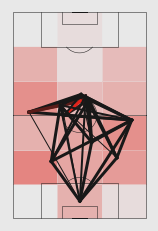

In [17]:
passing_networkWhoScored('Portugal', 13)

# **Field Tilt**

In [10]:
def field_Tilt(club, gameDay):

    if gameDay == 'All Season':
        touch = df.loc[(df.team == club) & (df['typedisplayName'] == 'Pass') & (df['outcomeTypedisplayName'] == 'Successful') & (df['x'] >=75)].reset_index(drop=True)
        
    elif gameDay != 'All Season':
        touch = df.loc[(df['Match_ID'] == gameDay) & (df['typedisplayName'] == 'Pass') & (df['isTouch'] == True) & (df['x'] >= 75)].reset_index(drop=True)

    #############################################################################################################################################

    home = touch['home_Team'].unique()
    home = home[0]
    color = clubColors.get(home)

    away = touch['away_Team'].unique()
    away = away[0]
    color2 = clubColors.get(away)

    home_Passes = touch.loc[(touch['isTouch'] == True) & (touch['team'] == home)]['typedisplayName'].count()
    away_Passes = touch.loc[(touch['isTouch'] == True) & (touch['team'] == away)]['typedisplayName'].count()

    passes_Total = touch.loc[(touch['isTouch'] == True)]['typedisplayName'].count()

    home_Passes = int(home_Passes)
    home_Passes = round((home_Passes / int(passes_Total)) * 100, 2)
    
    away_Passes = int(away_Passes)
    away_Passes = round((away_Passes / int(passes_Total)) * 100, 2)

    #############################################################################################################################################


    fieldTilt_Home = touch.loc[touch['team'] == home]

    fieldTilt_Home = round((len(fieldTilt_Home) / len(touch)) * 100, 2)

    fieldTilt_Away = touch.loc[touch['team'] == away]

    fieldTilt_Away = round((len(fieldTilt_Away) / len(touch)) * 100, 2)

    #############################################################################################################################################

    # Plotting the pitch

    fig, ax = plt.subplots(figsize=(6,4))

    pitch = Pitch(pitch_type='opta',
                    pitch_color='#E8E8E8', line_color='#181818',
                    line_zorder=3, linewidth=0.5, spot_scale=0.00)

    pitch.draw(ax=ax)

    fig.set_facecolor('#E8E8E8')

    #############################################################################################################################################

    ax.axvspan(75, 100, facecolor=color[0], alpha=0.68)

    ax.axvline(75, c='#181818', ls='--', lw=2)


    ax.axvspan(25, 0, facecolor='#ff0000', alpha=0.68)

    ax.axvline(25, c='#181818', ls='--', lw=2)

    #############################################################################################################################################

    for i in range(len(touch)):
        if touch['team'].values[i] == club:
            ax.scatter(100 - touch['x'].values[i] , 100 - touch['y'].values[i] , s = 30, color=color[0], edgecolor='#181818', alpha=0.8, zorder=5)
            
        elif touch['team'].values[i] != club:
            ax.scatter(touch['x'] , touch['y'] , s = 30, color=color2[0], edgecolor='#181818', alpha=0.8, zorder=5)

    #############################################################################################################################################

    #Params for the text inside the <> this is a function to highlight text
    highlight_textprops =\
        [{"color": color[0],"fontweight": 'bold'},
         {"color": color2[0],"fontweight": 'bold'}
         ]

    fig_text(s =f'<{home}>' + ' ' + 'vs' + ' ' + f'<{away}>',
             x = 0.55, y = 0.99,
             ha='center', va='center',
             highlight_textprops = highlight_textprops, 
             color='#181818', fontweight='bold',
             fontsize=14);
    
    fig_text(s =  'World Cup Catar 2022 | @menesesp20',
             x = 0.53, y = 0.951,
             color='#181818', fontweight='bold',
             ha='center', va='center',
             fontsize=5);

    fig_text(s = str(fieldTilt_Home) + ' ',
             x = 0.474, y = 0.225,
             color=color[0], fontweight='bold',
             ha='center', va='center',
             fontsize=7)

    fig_text(s = ' ' + '   ' + ' ',
             x = 0.512, y = 0.225,
             color=color2[0], fontweight='bold',
             ha='center', va='center',
             fontsize=7)
    
    fig_text(s = ' ' + str(fieldTilt_Away),
             x = 0.55, y = 0.225,
             color=color2[0], fontweight='bold',
             ha='center', va='center',
             fontsize=7)


    if (home_Passes < 50) & (fieldTilt_Home > 50):
        #Params for the text inside the <> this is a function to highlight text
        highlight_textprops =\
            [{"color": color[0],"fontweight": 'bold'},
            {"color": color[0],"fontweight": 'bold'},
            {"color": color2[0],"fontweight": 'bold'}  + '\n' ]

        fig_text(s = 'Despite' + ' ' + f'<{home}>' + ' ' + 'had less possession' + ' ' + '(' + f'<{str(home_Passes)}%>' + ')' + '\n' +
                 'they had greater ease in penetrating' + '\n' + 'the final third than' + ' ' +  f'<{away}>',
                 highlight_textprops = highlight_textprops,
                 x = 0.528, y = 0.87,
                 color='#181818', fontweight='bold',
                 ha='center', va='center',
                 fontsize=6)

    elif (away_Passes < 50) & (fieldTilt_Away > 50):
        #Params for the text inside the <> this is a function to highlight text
        highlight_textprops =\
            [{"color": color2[0],"fontweight": 'bold'},
            {"color": color2[0],"fontweight": 'bold'},
            {"color": color[0],"fontweight": 'bold'}]

        fig_text(s = 'Despite' + ' ' + f'<{away}>' + ' ' + 'had less possession' + ' ' + '(' + f'<{str(away_Passes)}%>' + ')' + '\n' +
                 'they had greater ease in penetrating' + '\n' + 'the final third than' + ' ' +  f'<{home}>',
                 highlight_textprops = highlight_textprops,
                 x = 0.528, y = 0.87,
                 color='#181818', fontweight='bold',
                 ha='center', va='center',
                 fontsize=6)

    elif (home_Passes > 50) & (fieldTilt_Home < 50):
        #Params for the text inside the <> this is a function to highlight text
        highlight_textprops =\
            [{"color": color[0],"fontweight": 'bold'},
            {"color": color[0],"fontweight": 'bold'},
            {"color": color2[0],"fontweight": 'bold'}]

        fig_text(s = 'Despite' + ' ' + f'<{home}>' + ' ' + 'had more possession' + ' ' + '(' + f'<{str(home_Passes)}%>' + ')' + '\n' +
                 'they struggled to penetrate' + '\n' + 'the last third than' + ' ' +  f'<{away}>',
                 highlight_textprops = highlight_textprops,
                 x = 0.528, y = 0.87,
                 color='#181818', fontweight='bold',
                 ha='center', va='center',
                 fontsize=6)

    elif (away_Passes > 50) & (fieldTilt_Away < 50):
        #Params for the text inside the <> this is a function to highlight text
        highlight_textprops =\
            [{"color": color2[0],"fontweight": 'bold'},
            {"color": color2[0],"fontweight": 'bold'},
            {"color": color[0],"fontweight": 'bold'}]

        fig_text(s = 'Despite' + ' ' + f'<{away}>' + ' ' + 'had more possession' + ' ' + '(' + f'<{str(away_Passes)}%>' + ')' + '\n' +
                 'they struggled to penetrate' + '\n' + 'the last third than' + ' ' +  f'<{home}>',
                 highlight_textprops = highlight_textprops,
                 x = 0.528, y = 0.87,
                 color='#181818', fontweight='bold',
                 ha='center', va='center',
                 fontsize=6)

    elif (fieldTilt_Home > fieldTilt_Away):
        fig_text(s = f'<{home}>' + ' ' + 'dominated the game with greater dominance' + '\n' + 'of the last third than their opponent' + ' ' + 
                    f'<{away}>.',
                    highlight_textprops = highlight_textprops,
                    x = 0.528, y = 0.87,
                    color='#181818', fontweight='bold',
                    ha='center', va='center',
                    fontsize=5)

    elif (fieldTilt_Home < fieldTilt_Away):
        highlight_textprops =\
        [{"color": color2[0],"fontweight": 'bold'},
        {"color": color[0],"fontweight": 'bold'}]
        
        fig_text(s = f'<{away}>' + ' ' + 'dominated the game with greater dominance' + '\n' + 'of the last third than their opponent' + ' ' + 
                 f'<{home}>.',
                 highlight_textprops = highlight_textprops,
                 x = 0.528, y = 0.89,
                 color='#181818', fontweight='bold',
                 ha='center', va='center',
                 fontsize=5)

    #############################################################################################################################################
    
    # Club Logo
    #fig = add_image(image='/content/drive/MyDrive/Data Hub - Drive/Code/Mundial' + '/' + club + '.png', fig=fig,
    #                left=0.06, bottom=0.85, width=0.05, height=0.09)

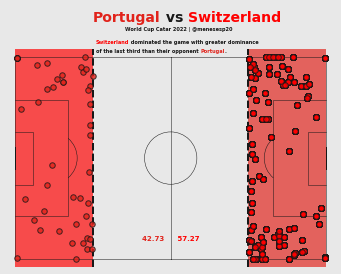

In [11]:
field_Tilt('Portugal', 13)